# Определение перспективного тарифа для телеком-компании
В данном проекте предстоить сделать предварительный анализ тарифов на небольшой выборке клиентов федерального оператора сотовой связи "Мегалайн".

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

### Цель исследования:

Помочь понять коммерческому департаменту какой тариф приносит больше денег. Это необходимо для дальнейшей корректировки рекламного бюджета.


### Задачи исследования:

- посчитать для каждого пользователя:
   - количество сделанных звонков и израсходованных минут разговора по месяцам;
   - количество отправленных сообщений по месяцам;
   - объем израсходованного интернет-трафика по месяцам;
   - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).
- проанализировать данные;
- проверить гипотезы:
   - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
   - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Исходные данные:

- Таблица users (информация о пользователях):
  - user_id — уникальный идентификатор пользователя
  - first_name — имя пользователя
  - last_name — фамилия пользователя
  - age — возраст пользователя (годы)
  - reg_date — дата подключения тарифа (день, месяц, год)
  - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
  - city — город проживания пользователя
  - tariff — название тарифного плана
- Таблица calls (информация о звонках):
  - id — уникальный номер звонка
  - call_date — дата звонка
  - duration — длительность звонка в минутах
  - user_id — идентификатор пользователя, сделавшего звонок
- Таблица messages (информация о сообщениях):
  - id — уникальный номер сообщения
  - message_date — дата сообщения
  - user_id — идентификатор пользователя, отправившего сообщение
- Таблица internet (информация об интернет-сессиях):
  - id — уникальный номер сессии
  - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
  - session_date — дата интернет-сессии
  - user_id — идентификатор пользователя
- Таблица tariffs (информация о тарифах):
  - tariff_name — название тарифа
  - rub_monthly_fee — ежемесячная абонентская плата в рублях
  - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
  - messages_included — количество сообщений в месяц, включённых в абонентскую плату
  - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
  - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
  - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
  - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Знакомство с данными


### Файл "calls" с информацией о количестве звонков

In [69]:
import pandas as pd
import pathlib

import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [70]:
#прочитаем из csv-файла данные о звонках пользователей
path_1 = pathlib.Path('C:/') / 'Ya' / 'datas' / 'calls.csv'

df1 = pd.read_csv(path_1)
display(df1.head()) # выводим первые 5 строк датафрейма
display(df1.info()) # смотрим общую информацию о данных

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

В этом файле имеем 202 607 строк и 4 поля, отсутствующих значений не налюдается , но необходимо привести информацию о дате в более удобный формат для дальнейшей работы.

### Плучим информацию о количестве звонков каждого пользователя по месяцам, для этого:
- переведём информацию в столбце "call_date" в формат даты;
- добавим столбец с информаций о том в каком месяце был совершён звонок;
- сгруппируем по этому столбцу исходные данные. 

In [71]:
df1['call_date'] = pd.to_datetime(df1['call_date'], format='%Y-%m-%d')
df1['month'] = df1['call_date'].dt.to_period('M')

calls = df1.pivot_table(index=[ 'user_id', 'month'], values='duration', aggfunc=['sum', 'count'])
calls.columns = ['duration_calls', 'count_calls']
calls.reset_index(inplace=True)
# посмотрим какие пользователи совершили больше всего звонков
calls = calls.sort_values(by='count_calls', ascending=False)
calls.head()

,user_id,month,duration_calls,count_calls
2972,1467,2018-12,1578.06,244
2359,1377,2018-03,1528.45,203
1359,1216,2018-12,1354.22,198
1400,1222,2018-10,1240.75,196
1243,1196,2018-12,1143.18,189


Теперь имеем таблицу с количеством звонков каждого из пользователей.

### Файл "internet" с информацией о количестве использованного трафика

In [72]:
path_2 = pathlib.Path('C:/') / 'Ya' / 'datas' / 'internet.csv'
df2 = pd.read_csv(path_2)
display(df2.head()) # выводим первые 5 строк датафрейма
display(df2.info()) # смотрим общую информацию о данных

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

### Получим информацию о количестве израсходованного трафика и числа интернет-сессий для каждого пользователя

In [73]:
# переводим столбец с датами в удобный для работы формат
df2['session_date'] = pd.to_datetime(df2['session_date'], format='%Y-%m-%d')
# выделяем период по каждому месяцу
df2['month'] = df2['session_date'].dt.to_period('M')

internet = df2.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = ['sum', 'count'])
internet.columns = ['mb_used', 'count_sessions']
internet.reset_index(inplace=True)
internet = internet.sort_values(by='mb_used', ascending=False)
internet.head()

,user_id,month,mb_used,count_sessions
799,1124,2018-10,49745.69,92
1524,1240,2018-08,48351.59,93
1622,1255,2018-07,45180.71,83
1901,1300,2018-11,44296.86,84
383,1060,2018-12,43931.36,83


Получили наглядную информацию об активности пользователей в интернете.

### Файл "messages" с информацией о количестве отправленных сообщений

In [74]:
path_3 = pathlib.Path('C:/') / 'Ya' / 'datas' / 'messages.csv'
df3 = pd.read_csv(path_3)
display(df3.head()) # выводим первые 5 строк датафрейма
display(df3.info()) # смотрим общую информацию о данных

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

### Строим таблицу с информацией о количестве отправленных сообщений

In [75]:
df3['message_date'] = pd.to_datetime(df3['message_date'], format = '%Y-%m-%d')
#df3['month'] = df3['message_date'].dt.month
df3['month'] = df3['message_date'].dt.to_period('M')
message = df3.pivot_table(index = ['user_id', 'month'], values = 'id', aggfunc = 'count')
message.columns = ['count_messages']
message.reset_index(inplace=True)
message = message.sort_values(by='count_messages', ascending=False)
message.head()

,user_id,month,count_messages
866,1165,2018-12,224
154,1028,2018-10,223
1197,1231,2018-07,211
1196,1231,2018-06,201
865,1165,2018-11,197


Таким образом, получили наглядную информацию о количестве отправленных сообщений.

### Файл "users" c информацией о пользователях

In [76]:
path_4 = pathlib.Path('C:/') / 'Ya' / 'datas' / 'users.csv'
df4 = pd.read_csv(path_4)
display(df4.head()) # выводим первые 5 строк датафрейма
display(df4.info()) # смотрим общую информацию о данных

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

Хороший набор данных с информацией о 500 пользователях.

### Сбор полученных данных по активности пользователей в общую таблицу

In [77]:
data = calls.merge(internet, on=['user_id', 'month'], how='outer')
data = data.merge(message, on=['user_id', 'month'], how='outer')
data = data.merge(df4, on=['user_id'], how='outer')
data.head()


,user_id,month,duration_calls,count_calls,mb_used,count_sessions,count_messages,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1467,2018-12,1578.06,244.0,9756.90,22.0,39.0,66,NaN,Киров,Исак,Александрюк,2018-11-24,ultra
1,1467,2018-11,300.15,52.0,2450.04,5.0,15.0,66,NaN,Киров,Исак,Александрюк,2018-11-24,ultra
2,1377,2018-03,1528.45,203.0,3059.85,7.0,20.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra
3,1377,2018-12,1179.83,185.0,1444.81,6.0,17.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra
4,1377,2018-07,1237.87,185.0,4205.46,9.0,13.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra


In [78]:
data.shape # посмотрим на количество строк и полей

(3216, 14)

In [79]:
data.user_id.nunique() # убедимся, что все 500 пользователй попали в общий набор данных

500

Теперь мы обладаем набором данных с общей активностью пользователей нашего оператора связи.

### Переведём количество использованных мегабайт в гигабайты

In [80]:
# разделим значения столбца "mb_used" на 1000 и используем функцию ceil для округления к большему значению
data['gb_used'] = np.ceil(data['mb_used'] / 1000)
data.head()

,user_id,month,duration_calls,count_calls,mb_used,count_sessions,count_messages,age,churn_date,city,first_name,last_name,reg_date,tariff,gb_used
0,1467,2018-12,1578.06,244.0,9756.90,22.0,39.0,66,NaN,Киров,Исак,Александрюк,2018-11-24,ultra,10.0
1,1467,2018-11,300.15,52.0,2450.04,5.0,15.0,66,NaN,Киров,Исак,Александрюк,2018-11-24,ultra,3.0
2,1377,2018-03,1528.45,203.0,3059.85,7.0,20.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,4.0
3,1377,2018-12,1179.83,185.0,1444.81,6.0,17.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,2.0
4,1377,2018-07,1237.87,185.0,4205.46,9.0,13.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,5.0


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype    
---  ------          --------------  -----    
 0   user_id         3216 non-null   int64    
 1   month           3214 non-null   period[M]
 2   duration_calls  3174 non-null   float64  
 3   count_calls     3174 non-null   float64  
 4   mb_used         3203 non-null   float64  
 5   count_sessions  3203 non-null   float64  
 6   count_messages  2717 non-null   float64  
 7   age             3216 non-null   int64    
 8   churn_date      189 non-null    object   
 9   city            3216 non-null   object   
 10  first_name      3216 non-null   object   
 11  last_name       3216 non-null   object   
 12  reg_date        3216 non-null   object   
 13  tariff          3216 non-null   object   
 14  gb_used         3203 non-null   float64  
dtypes: float64(6), int64(2), object(6), period[M](1)
memory usage: 402.0+ KB


In [82]:
data.describe()

,user_id,duration_calls,count_calls,mb_used,count_sessions,count_messages,age,gb_used
count,3216.000000,3174.000000,3174.000000,3203.000000,3203.000000,2717.000000,3216.000000,3203.000000
mean,1251.588930,431.250800,63.833333,17266.708626,46.642523,45.283769,46.643968,17.758664
std,144.645928,224.914227,32.678036,7516.356902,18.696094,35.051363,16.581233,7.522742
min,1000.000000,0.000000,1.000000,0.000000,1.000000,1.000000,18.000000,0.000000
25%,1125.000000,273.835000,41.000000,12526.905000,35.000000,19.000000,32.000000,13.000000
50%,1253.000000,420.715000,63.000000,16963.110000,48.000000,38.000000,46.000000,17.000000
75%,1378.250000,558.602500,83.000000,21432.175000,59.000000,63.000000,62.000000,22.000000
max,1499.000000,1578.060000,244.000000,49745.690000,118.000000,224.000000,75.000000,50.000000


In [83]:
data.isna().sum()

user_id              0
month                2
duration_calls      42
count_calls         42
mb_used             13
count_sessions      13
count_messages     499
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
gb_used             13
dtype: int64

Из информации по полученным данным видим, что во многих столбцах встречаются отсутствующие значения.

- Строки в которых нет информации о месяце в кототором была совершена операция мы попросту удалим, так как таких строк всего две и это ни как не повлияет на наш набор данных;
- В строках где пропущена информация о продолжительности и количестве звонков - заменим эти значения на ноль. Вероятнее всего, отсутствующие значения означают, что звонки не совершались;
- Пропущенные значения в столбцах с информацией о количесвтве использованного трафика и о количестве интернет-сессий, мы также заменяем нулями. Судя по всему, остались абоненты непризнающие интернет;
- В столбце с информацией о количестве отправленных сообщений , будем заменять отсутствующие значения на ноль, так как с развитием интернет-сервисов, СМСки всё дальше отдалются от абонентов - отсюда и 499 отсутствующих значений в этом столбце;
- Столбец "churn_date" - это дата прекращения пользования тарифом, если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Пропущенные значения в этом столбце оставим без изменений.

In [84]:
data.dropna(subset=['month'], inplace=True)
data.loc[data['duration_calls'].isna(), 'duration_calls'] = 0
data.loc[data['count_calls'].isna(), 'count_calls'] = 0
data.loc[data['mb_used'].isna(), 'mb_used'] = 0
data.loc[data['gb_used'].isna(), 'gb_used'] = 0
data.loc[data['count_sessions'].isna(), 'count_sessions'] = 0
data.loc[data['count_messages'].isna(), 'count_messages'] = 0
data.isna().sum()

user_id              0
month                0
duration_calls       0
count_calls          0
mb_used              0
count_sessions       0
count_messages       0
age                  0
churn_date        3027
city                 0
first_name           0
last_name            0
reg_date             0
tariff               0
gb_used              0
dtype: int64

## Расчет выручки

- Для каждого из тарифа создаём дополнительные столбцы с информацией о прибыли сверх абонентской платы со звонков, интернета и сообщений, исходя из условий рассматриваемого тарифа;
- Если значения в столбце о прибыли сверх абонентской платы со звонков, интернета или сообщений оказываются отрицательными - это значит, что абонент не пользовался услугами оператора сверх заложенных в тариф лимитов, таким образом, для дальнейшего расчёта общей прибыли такие значения мы преобразуем в 0;
- Для каждого из тарифа посчитаем общую выручку: сложим ежемесячную абоненскую плату со значениями из столбцов с информацией о прибыли сверх абонентской платы.

In [85]:
data.loc[data['tariff'] == 'ultra', 'receipt_from_calls'] = data['duration_calls'] - 3000
data.loc[data['tariff'] == 'ultra', 'receipt_from_internet'] = (data['gb_used'] - 30) * 150
data.loc[data['tariff'] == 'ultra', 'receipt_from_messages'] = data['count_messages'] - 1000

data.loc[data['tariff'] == 'smart', 'receipt_from_calls'] = (data['duration_calls'] - 500) * 3
data.loc[data['tariff'] == 'smart', 'receipt_from_internet'] = (data['gb_used'] - 15) * 200
data.loc[data['tariff'] == 'smart', 'receipt_from_messages'] = (data['count_messages'] - 50) * 3

data.loc[data['receipt_from_calls'] < 0, 'receipt_from_calls'] = 0
data.loc[data['receipt_from_internet'] < 0, 'receipt_from_internet'] = 0
data.loc[data['receipt_from_messages'] < 0, 'receipt_from_messages'] = 0

data.loc[data['tariff'] == 'ultra', 'receipt'] = 1950 + data['receipt_from_calls'] + data['receipt_from_internet'] + data['receipt_from_messages']
data.loc[data['tariff'] == 'smart', 'receipt'] = 550 + data['receipt_from_calls'] + data['receipt_from_internet'] + data['receipt_from_messages']
data.head(60)

,user_id,month,duration_calls,count_calls,mb_used,count_sessions,count_messages,age,churn_date,city,first_name,last_name,reg_date,tariff,gb_used,receipt_from_calls,receipt_from_internet,receipt_from_messages,receipt
0,1467,2018-12,1578.06,244.0,9756.90,22.0,39.0,66,NaN,Киров,Исак,Александрюк,2018-11-24,ultra,10.0,0.00,0.0,0.0,1950.00
1,1467,2018-11,300.15,52.0,2450.04,5.0,15.0,66,NaN,Киров,Исак,Александрюк,2018-11-24,ultra,3.0,0.00,0.0,0.0,1950.00
2,1377,2018-03,1528.45,203.0,3059.85,7.0,20.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,4.0,0.00,0.0,0.0,1950.00
3,1377,2018-12,1179.83,185.0,1444.81,6.0,17.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,2.0,0.00,0.0,0.0,1950.00
4,1377,2018-07,1237.87,185.0,4205.46,9.0,13.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,5.0,0.00,0.0,0.0,1950.00
5,1377,2018-10,1324.75,178.0,4880.62,11.0,10.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,5.0,0.00,0.0,0.0,1950.00
6,1377,2018-06,1222.79,176.0,4717.58,10.0,15.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,5.0,0.00,0.0,0.0,1950.00
7,1377,2018-09,1223.32,173.0,4134.29,8.0,17.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,5.0,0.00,0.0,0.0,1950.00
8,1377,2018-11,1097.94,164.0,5998.50,10.0,16.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,6.0,0.00,0.0,0.0,1950.00
9,1377,2018-08,1200.67,161.0,5749.01,10.0,11.0,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,6.0,0.00,0.0,0.0,1950.00


Посмотрим как отличается средняя выручка от пользователей двух рассматриваемых тарифов, а также средние значения по продолжительности звонков, использоваемого трафика и отправленных сообщений:

In [86]:
data['receipt'].describe()

count    3214.000000
mean     1551.029564
std       816.670098
min       550.000000
25%       750.000000
50%      1746.980000
75%      1950.000000
max      6813.100000
Name: receipt, dtype: float64

In [87]:
pivot = data.pivot_table(index = 'tariff', values =['receipt', 'duration_calls', 'gb_used', 'count_messages'] )
pivot

,count_messages,duration_calls,gb_used,receipt
tariff,,,,
smart,33.384029,394.427026,16.695828,1313.148955
ultra,49.363452,497.068223,19.965482,2089.340102


Из получившейся сводной таблицы видим:
- количство отправленных сообщений у пользователей тарифа "Ультра" не значительно превышает количство сообщений пользователей тарифа "Смарт". В том и другом тарифе пользователи практически никогда не отправлют большее число сообщений чем предусмотрено в тарифе;
- продолжительность звонков также редко превышает допустимую тарифом норму;
- по использованию трафика видно, что в среднем пользователям тарифа "Смарт" недостаточно выделенных их тарифом 15 Гб;
- средняя выручка с пользователей тарифа "Ультра" значительно выше, чем у "Смарт", что очевидно, так как за тариф "Ультра" более высокая абонентская плата по сравнению с тарифом "Смарт".
 

## Описание распределений 

Построим гистограммы использования услуг оператора для абонентов каждого из тарифа:

In [88]:
def get_hist(tariff_name_1, tariff_name_2, service, title_1, title_2, x_label):
    """ Эта функция для созданя гистограмм, а также рассчета дисперсии и стандартного отклонения 
    
    На вход она принимает: название рассматриваемых тарифов, показатель по которому строим распределение,
    названия заголовков и подпись по оси Х
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.hist(data.loc[data['tariff'] == tariff_name_1, service], bins=20)
    ax1.set_title(title_1)
    ax1.set_xlabel(x_label)

    ax2.hist(data.loc[data['tariff'] == tariff_name_2, service], bins=20)
    ax2.set_title(title_2)
    ax2.set_xlabel(x_label)
    
    plt.show()
    
    print()
    print()
    var_calls = np.var(data[service]) #считаем дисперсию данных продолжительности звонков
    print('Дисперсия равна', var_calls)
    print('Стандартное отклонение:', np.sqrt(var_calls))
    pass

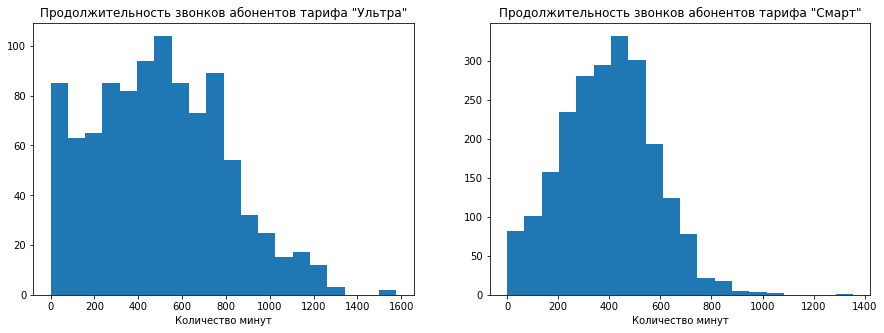



Дисперсия равна 52226.8773420229
Стандартное отклонение: 228.53200507154986


In [89]:
# с помощью фукции строим гистограммы распределения продолжительности звонков на каждом из тарифов
# выводим информацию о дисперсии и стандартном отклонении продолжительности звонков

get_hist('ultra', 'smart', 'duration_calls'
         , 'Продолжительность звонков абонентов тарифа "Ультра"'
         , 'Продолжительность звонков абонентов тарифа "Смарт"'
         , 'Количество минут')

**Вывод:** в основном, пользователи тарифа "Ультра" тратят от 200 до 800 минут в месяц, тогда как у большинства пользователей тарифа "Смарт"  количество потраченных минут -  от 300 до 550.

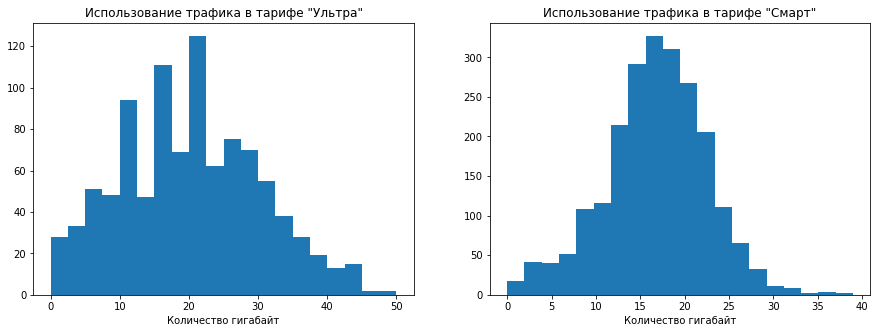



Дисперсия равна 57.456019170175196
Стандартное отклонение: 7.579974879257529


In [90]:
# строим гистограммы распределения использования трафика на каждом из тарифов
# выводим информацию о дисперсии и стандартном отклонении количества используемого трафика

get_hist('ultra', 'smart', 'gb_used'
         , 'Использование трафика в тарифе "Ультра"'
         , 'Использование трафика в тарифе "Смарт"'
         , 'Количество гигабайт')

**Вывод:** абоненты и того и другого тарифа используют примерно одинаковое количество трафика - от 10 до 30 гигабайт в месяц.

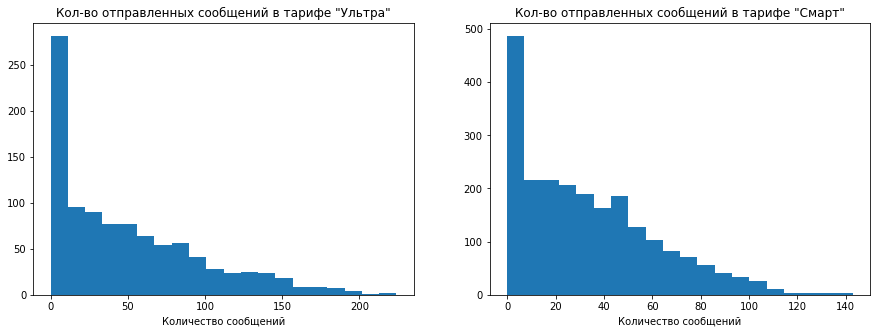



Дисперсия равна 1306.294876297659
Стандартное отклонение: 36.142701563353825


In [91]:
# строим гистограммы распределения кол-ва отправленный сообщений на каждом из тарифов
# выводим информацию о дисперсии и стандартном отклонении количества отправляемых сообщений

get_hist('ultra', 'smart', 'count_messages'
         , 'Кол-во отправленных сообщений в тарифе "Ультра"'
         , 'Кол-во отправленных сообщений в тарифе "Смарт"'
         , 'Количество сообщений')

**Вывод:** в каждом из рассматриваемых тарифов пользователи отправлят значительно меньше сообщений чем заложено в объем предоставляемого тарифа.

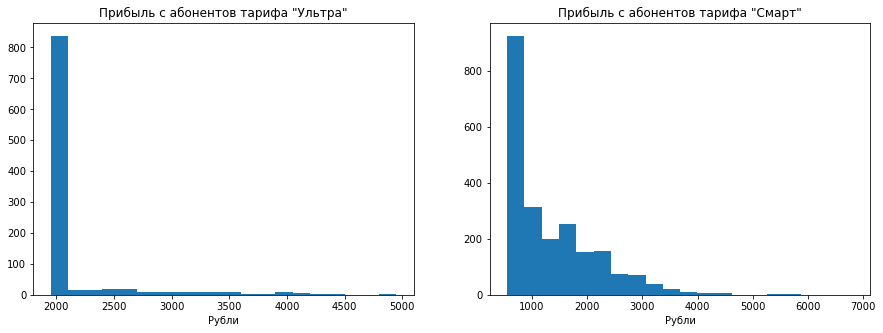



Дисперсия равна 666742.5353638417
Стандартное отклонение: 816.5430395048638


In [92]:
# строим гистограммы распределения прибыли с абонентов каждого из тарифа
# выводим информацию о дисперсии и стандартном отклонении прибыли

get_hist('ultra', 'smart', 'receipt'
         , 'Прибыль с абонентов тарифа "Ультра"'
         , 'Прибыль с абонентов тарифа "Смарт"'
         , 'Рубли')

**Вывод:** из полученных гистограмм видим, что пользователям тарифа "Ультра", как правило, хватает предостваляемых в месяц услуг в рамках тарифа, так как плата большинства абонентов не превышает ежемесячной стоимости тарифа в размере 1950 рублей. Однако же, в менее дорогом тарифе "Смарт" пользователи покупают дополнительные услуги сверх тарифа значительно чаще. 

## Проверка гипотез

**Н0_1(Нулевая гипотеза):** Средняя выручка пользователей тарифа "Ультра" и "Смарт" равна

**Н1_1(альтернативная гипотеза):** Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [93]:
from scipy import stats as st
sample1 = data.loc[data['tariff'] == 'ultra', 'receipt']
sample2 = data.loc[data['tariff'] == 'smart', 'receipt']
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(sample1, sample2, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print("Не получилось отвергнуть нулевую гипотезу")
else:
    print("Отвергаем нулевую гипотезу") 

p-значение: 1.2539030303847291e-228
Отвергаем нулевую гипотезу


**Вывод:** Отвергаем нулевую гипотезу и принимаем альтернативную.

Статистическая проверка показала, что средняя выручка с пользователей двух рассматриваемых тарифов - различается. 

**Н0_2(Нулевая гипотеза):** Средняя выручка пользователей из Москвы и пользователей из других регионов - равна.

**Н1_2(альтернативная гипотеза):** Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [94]:
sample3 = data.loc[data['city'] == 'Москва', 'receipt']
sample4 = data.loc[data['city'] != 'Москва', 'receipt']
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(sample3, sample4, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue > alpha:
    print("Не получилось отвергнуть нулевую гипотезу")
else:
    print("Отвергаем нулевую гипотезу") 

p-значение: 0.5212625555900344
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Принимаем нулевую гипотезу.

Статистическая проверка показала, что средняя выручка абонентов из Москвы не отличается от выручки с абонентов из других регионов

## Общий вывод

- Пользователям тарифа "Смарт" очень часто не хватает выделенного тарифом интрнет трафика, и они вынуждены платить сверх тарифа гораздо чаще пользователей тарифа "Ультра";
- В совокупности все пользователи редко используют заложенные в тариф сообщения, вероятнее всего это связано с тем, что сейчас мы чаще общаемся в соц.сетях либо онлайн мессенджерах;
- Длительность же звонков у пользователей тарифа "Ультра" значительно больше чем у пользователей тарифа "Смарт".